Please consider upvoting if you find this notebook useful. Feel free to leave feedbacks and suggestions in the comments. They are always highly appreciated. Thank you.

## Synopsis
1. <b>ResNet50</b> - Data augmentation, batchnormalization, dropout with 0.3 rate, learning_rate = 0.0001 (Adam)
2. <b>InceptionV3</b> - Data augmentation, batchnormalization, dropout with 0.3 rate, learning_rate = 0.0001 (RMSprop)
3. <b>EfficientNetB7</b> - Data augmentation, GlobalAveragePoolong2D, batchnormalization, dropout with 0.3 rate, learning_rate = 0.0001 (Adam)
4. <b>Ensemble Model</b> - Test Accuracy: <b>0.9297</b>

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import libraries

In [22]:
from random import random, seed, randint
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.applications import resnet, inception_v3, efficientnet
from keras.callbacks import ModelCheckpoint
from keras.metrics import Precision, Recall
from keras.optimizers import Adam, RMSprop
from keras.utils import img_to_array, array_to_img, load_img
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
pip install -q git+https://github.com/cleanlab/cleanvision.git

Note: you may need to restart the kernel to use updated packages.


In [9]:
# For checking issues in the training images
from cleanvision.imagelab import Imagelab

## Access and visualize data

In [11]:
# Copy train folders in /kaggle/working for manipulation
working_dir = './kaggle/working/'
src = './kaggle/input/intel-image-classification/seg_train/seg_train/'
dst = working_dir + 'seg_train/'
shutil.copytree(src, dst)

'./kaggle/working/seg_train/'

In [42]:
# Copy test folders in /kaggle/working
src = './kaggle/input/intel-image-classification/seg_test/seg_test/'
dst = working_dir + 'seg_test/'
shutil.copytree(src, dst)

'/kaggle/working/seg_test/'

In [13]:
train_path = './kaggle/working/seg_train/'
test_path = './kaggle/working/seg_test/'
train_folders = sorted(os.listdir(train_path))
test_folders = sorted(os.listdir(test_path))
print('Training classes: {}'.format(train_folders))
print('Testing classes: {}'.format(test_folders))

Training classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Testing classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Number of samples in buildings is 2191


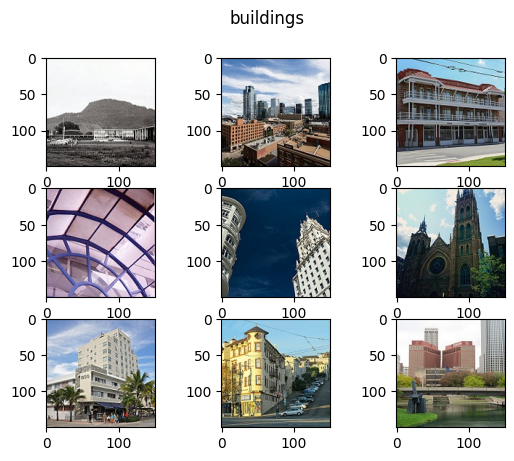

Number of samples in forest is 2271


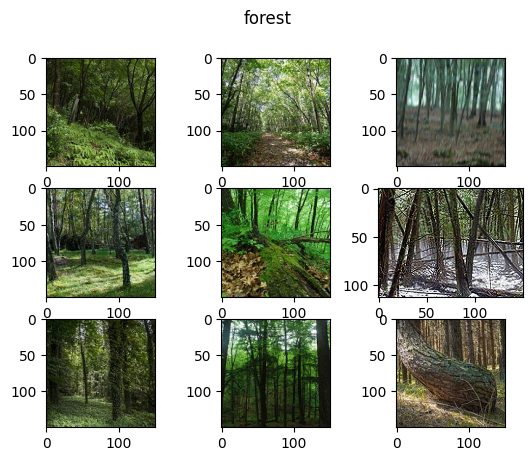

Number of samples in glacier is 2404


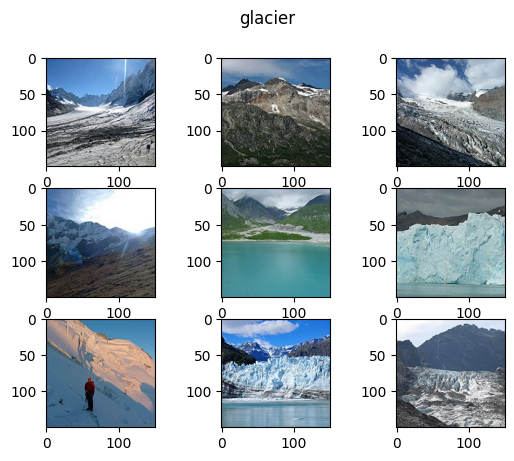

Number of samples in mountain is 2512


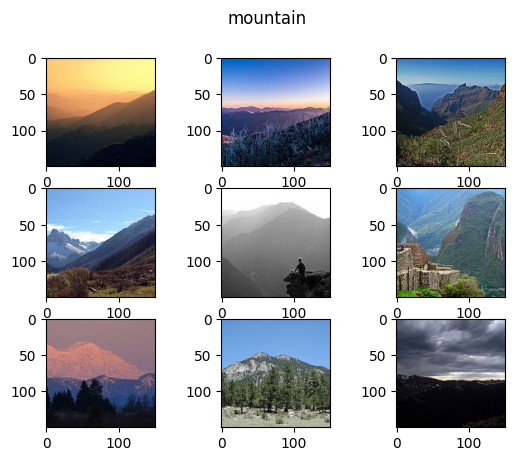

Number of samples in sea is 2274


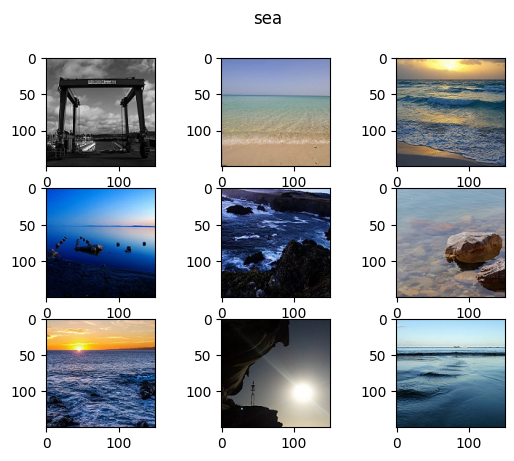

Number of samples in street is 2382


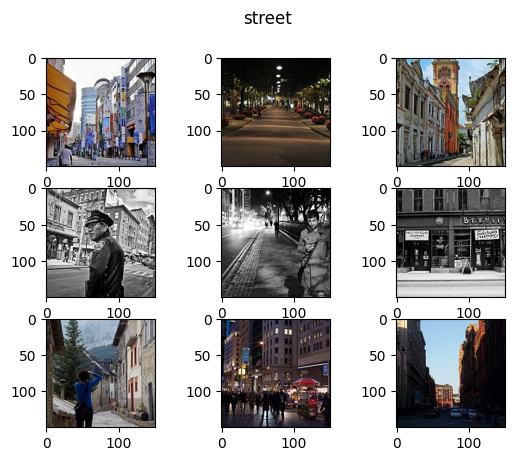

In [14]:
for folder in train_folders:
    filenames = os.listdir(train_path + folder)
    print('Number of samples in {} is {}'.format(folder, len(filenames)))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        filepath = train_path + folder + '/' + filenames[i]
        image = imread(filepath)
        plt.imshow(image)
    plt.suptitle(folder)
    plt.show()

All 9 images from each class look consistent in size and the categorization looks correct visually. But it is good to ensure if there are any images with bad quality.

## Data Preparation <br>

Check for issues in image (dark, blurry, duplicates, odd_aspect_ratio, light) using the awesome cleanvision package<br>
Check for each class folder in seg_train<br>
Reference: https://github.com/cleanlab/cleanvision


buildings

Reading images from C:\ML_Prep\ML_Engg_Prep\image_learning\intel_images_scenes_multiclass_classification\kaggle\working\seg_train\buildings
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2191/2191 [00:03<00:00, 687.19it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type      |   num_images |
|---:|:----------------|-------------:|
|  0 | near_duplicates |            2 | 

Found 1 set of images with near_duplicates issue in the dataset.
Set: 0


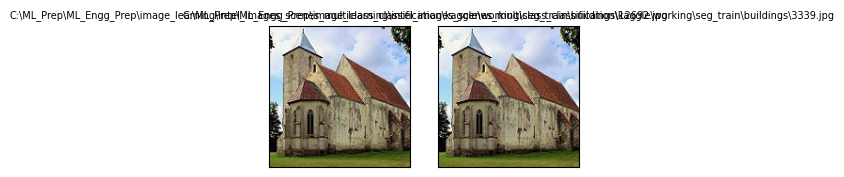


forest

Reading images from C:\ML_Prep\ML_Engg_Prep\image_learning\intel_images_scenes_multiclass_classification\kaggle\working\seg_train\forest
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2271/2271 [00:03<00:00, 672.94it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | near_duplicates  |           32 |
|  1 | dark             |            5 |
|  2 | exact_duplicates |            4 | 


Top 4 sets of images with near_duplicates issue
Set: 0


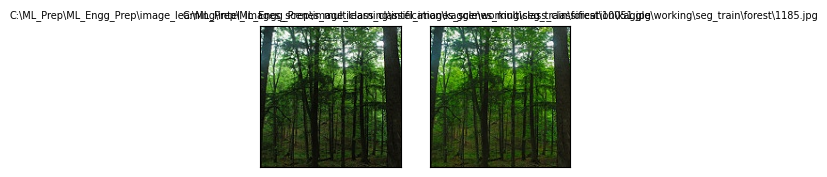

Set: 1


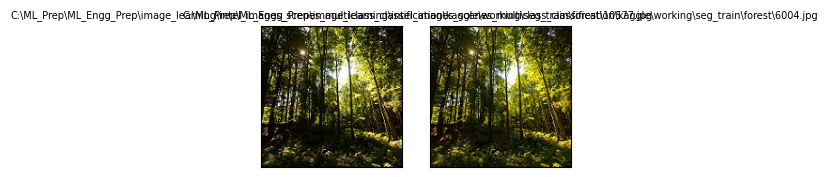

Set: 2


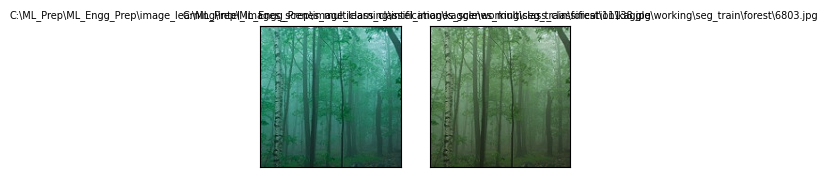

Set: 3


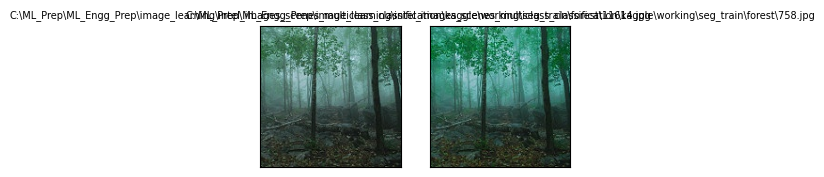


Top 4 examples with dark issue in the dataset.


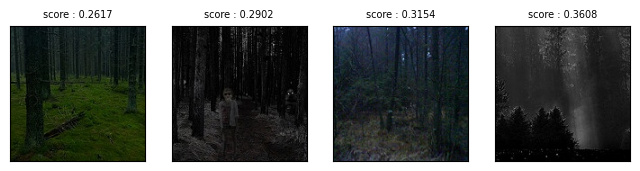

Found 2 sets of images with exact_duplicates issue in the dataset.
Set: 0


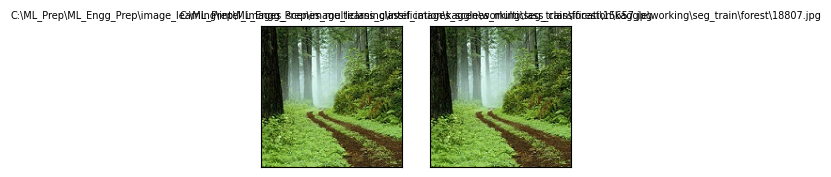

Set: 1


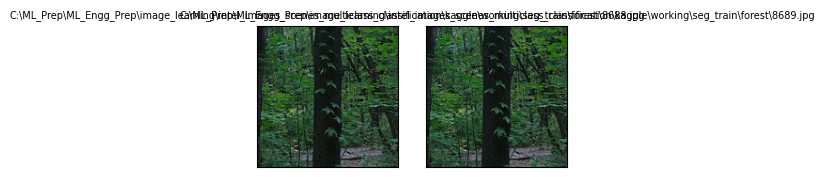


glacier

Reading images from C:\ML_Prep\ML_Engg_Prep\image_learning\intel_images_scenes_multiclass_classification\kaggle\working\seg_train\glacier
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2404/2404 [00:03<00:00, 737.77it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type      |   num_images |
|---:|:----------------|-------------:|
|  0 | near_duplicates |            4 | 

Found 2 sets of images with near_duplicates issue in the dataset.
Set: 0


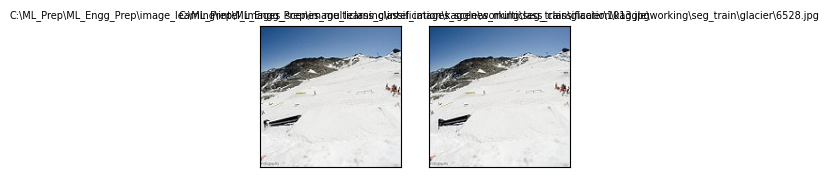

Set: 1


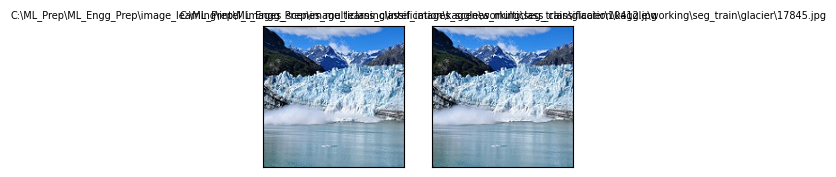


mountain

Reading images from C:\ML_Prep\ML_Engg_Prep\image_learning\intel_images_scenes_multiclass_classification\kaggle\working\seg_train\mountain
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2512/2512 [00:03<00:00, 745.89it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type      |   num_images |
|---:|:----------------|-------------:|
|  0 | near_duplicates |            8 |
|  1 | blurry          |            1 | 


Top 4 sets of images with near_duplicates issue
Set: 0


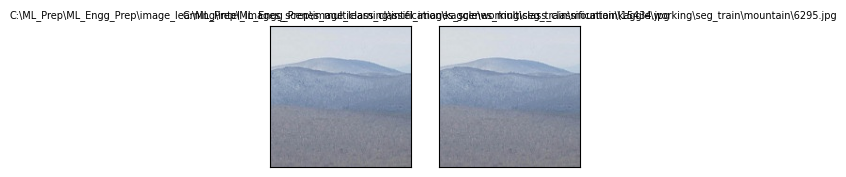

Set: 1


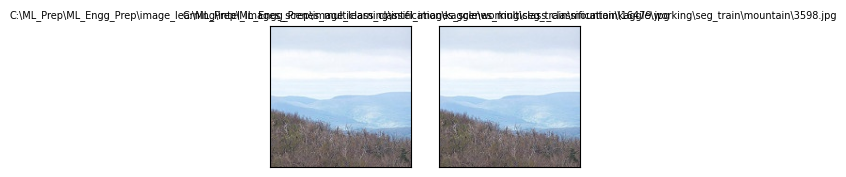

Set: 2


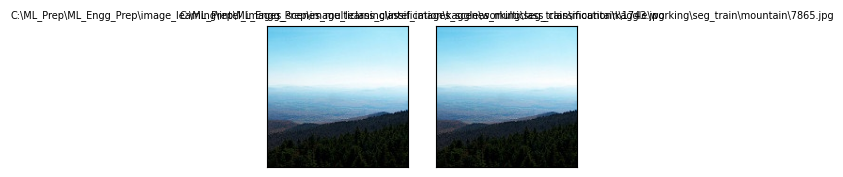

Set: 3


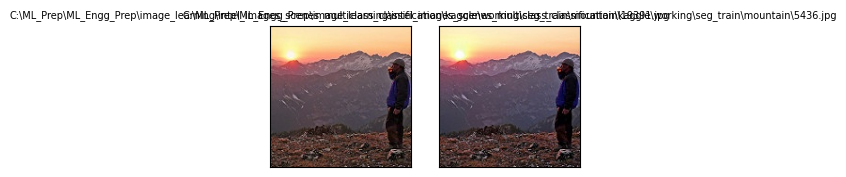

Found 1 example with blurry issue in the dataset.


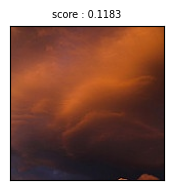


sea

Reading images from C:\ML_Prep\ML_Engg_Prep\image_learning\intel_images_scenes_multiclass_classification\kaggle\working\seg_train\sea
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2274/2274 [00:03<00:00, 704.39it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |            2 |
|  1 | near_duplicates  |            2 | 

Found 1 set of images with exact_duplicates issue in the dataset.
Set: 0


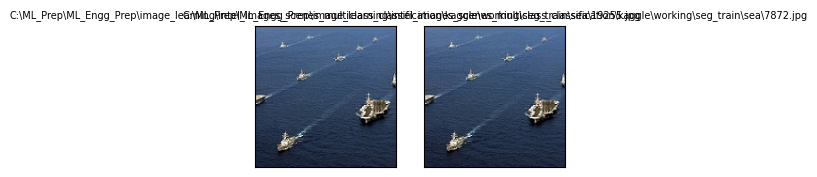

Found 1 set of images with near_duplicates issue in the dataset.
Set: 0


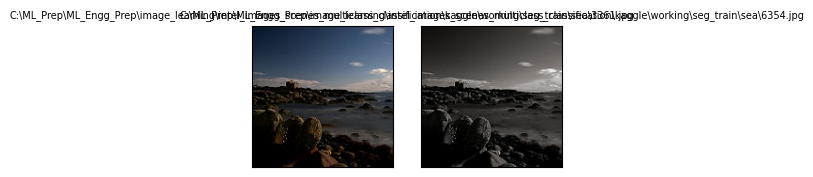


street

Reading images from C:\ML_Prep\ML_Engg_Prep\image_learning\intel_images_scenes_multiclass_classification\kaggle\working\seg_train\street
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:03<00:00, 732.19it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |            4 |
|  1 | near_duplicates  |            2 | 

Found 2 sets of images with exact_duplicates issue in the dataset.
Set: 0


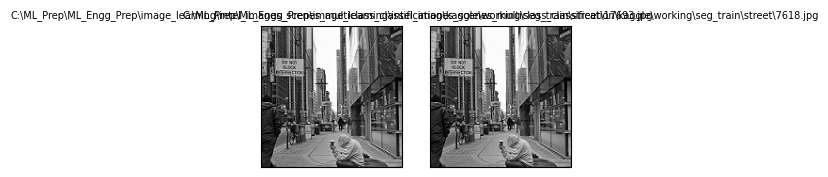

Set: 1


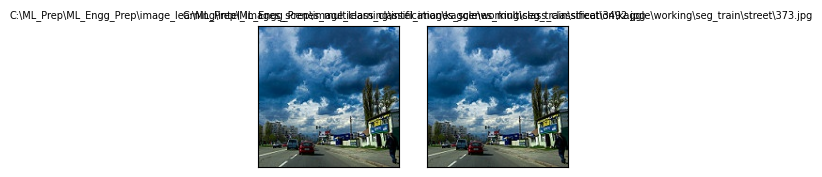

Found 1 set of images with near_duplicates issue in the dataset.
Set: 0


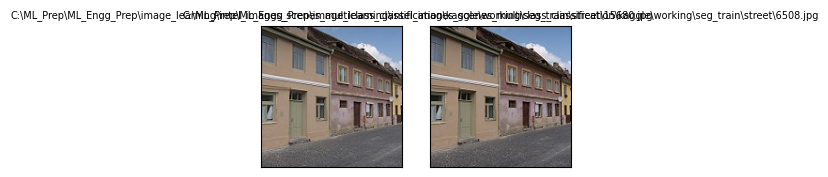

In [15]:
for folder in train_folders:
    print('\n' + folder + '\n')
    imagelab_instance = Imagelab(data_path = train_path + folder)
    imagelab_instance.find_issues()
    imagelab_instance.report()

Looks like most of the issues found in the images are near or exact duplicates. This is fine and there is no need to remove the near duplicates (kind of data augmentation ingrained in the dataset). There is one blurry image found in the 'mountain' folder. We will remove this image from the training dataset.

In [16]:
# Find blurry images in mountain training folder
imagelab_mountain = Imagelab(data_path = train_path + 'mountain/')
imagelab_mountain.find_issues()
# Remove images with blurriness issue
blurry_mountain = imagelab_mountain.issues[imagelab_mountain.issues['is_blurry_issue']==True]\
.index.tolist()
print(blurry_mountain)

Reading images from C:\ML_Prep\ML_Engg_Prep\image_learning\intel_images_scenes_multiclass_classification\kaggle\working\seg_train\mountain
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|█████████████████████████████████████████████████████████████████████████████| 2512/2512 [00:03<00:00, 816.78it/s]

Issue checks completed. To see a detailed report of issues found, use imagelab.report().
['C:\\ML_Prep\\ML_Engg_Prep\\image_learning\\intel_images_scenes_multiclass_classification\\kaggle\\working\\seg_train\\mountain\\14283.jpg']


In [17]:
# Remove blurry mountain files
for file in blurry_mountain:
    os.remove(file)

Split data from seg_train into training and validation for model building <br>
Use data from seg_test for model testing


In [18]:
# Generate Training and Validation folders
subdirs = ['Training/', 'Validation/']
labeldirs = ['buildings/', 'forest/', 'glacier/', 'mountain/', 'sea/', 'street/']
for subdir in subdirs:
    for labldir in labeldirs:
        os.makedirs(working_dir + subdir + labldir, exist_ok=False)

In [19]:
# Create a balanced training and validation dataset with 80%-20% split
# So classification accuracy will work as a good model indicator
seed(42)
val_ratio = 0.20
for folder in train_folders:
    filenames = os.listdir(train_path + folder)
    for file in filenames:
        src = train_path + folder + '/' + file
        dst = working_dir + 'Training/' + folder + '/' + file
        if random() < val_ratio:
            dst = working_dir + 'Validation/' + folder + '/' + file
        shutil.copyfile(src, dst)

In [20]:
for folder in train_folders:
    print(folder + ' training samples: {}'.format(len(os.listdir(working_dir + 'Training/' + folder))))
    print(folder + ' validation samples: {}\n'.format(len(os.listdir(working_dir + 'Validation/' + folder))))

buildings training samples: 1780
buildings validation samples: 411

forest training samples: 1805
forest validation samples: 466

glacier training samples: 1903
glacier validation samples: 501

mountain training samples: 1988
mountain validation samples: 523

sea training samples: 1833
sea validation samples: 441

street training samples: 1894
street validation samples: 488



## Generate functions for summarizing diagnostics and running validation harness

In [24]:
def summarize_diagnostics(history, plot_file):
    plt.subplot(2, 2, 1)
    plt.title('Cross-entropy loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.legend(loc='best')
    plt.subplot(2, 2, 2)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='validation')
    plt.legend(loc='best')
    plt.savefig(plot_file)
    plt.show()

In [38]:
def run_validation_harness(model, preprocess_config, model_name):
    model.summary()    
    # With Data Augmentation
    train_datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True,\
                                          fill_mode='nearest', width_shift_range=0.1,\
                                          height_shift_range=0.1, preprocessing_function=preprocess_config.preprocess_input)
    validate_datagen = ImageDataGenerator(preprocessing_function=preprocess_config.preprocess_input)
    train_iterator = train_datagen.flow_from_directory(working_dir + 'Training/', class_mode='categorical',\
                                                         batch_size=32, target_size=(224, 224))
    validate_iterator = validate_datagen.flow_from_directory(working_dir + 'Validation/', class_mode='categorical',\
                                                         batch_size=32, target_size=(224, 224))
    #save best weight
    checkpoints = ModelCheckpoint(filepath=model_name + '_weights.hdf5', save_best_only=True,\
                                 save_weights_only=True)
    history = model.fit(train_iterator, validation_data=validate_iterator, epochs=100, verbose=2,\
                       steps_per_epoch=len(train_iterator),\
                        validation_steps=len(validate_iterator), callbacks=[checkpoints])
    #model.save(model_name + '_model.h5')
    loss, acc, precision, recall = model.evaluate(validate_iterator, verbose=2)
    print('Loss: {}'.format(loss))
    print('Accuracy: {}'.format(acc*100.0))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    summarize_diagnostics(history, model_name + '_curves.png')
    return model

## Transfer Learning with ResNet5, InceptionV3, EfficientNetB7

In [26]:
# ResNet50
def ResNet50_TL():
    model = Sequential()
    model.add(resnet.ResNet50(include_top=False, pooling='max', weights='imagenet', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    model.add(Dense(6, activation='softmax', kernel_initializer='he_uniform'))
    model.layers[0].trainable = False
    opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    model.compile(optimizer=opt, loss='categorical_crossentropy',\
                 metrics=['accuracy', Precision(thresholds=0.5), Recall(thresholds=0.5)])
    return model

# InceptionV3
def InceptionV3_TL():
    model = Sequential()
    model.add(inception_v3.InceptionV3(include_top=False, pooling='max', weights='imagenet', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    model.add(Dense(6, activation='softmax', kernel_initializer='he_uniform'))
    model.layers[0].trainable = False
    opt = RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-7)
    model.compile(optimizer=opt, loss='categorical_crossentropy',\
                 metrics=['accuracy', Precision(thresholds=0.5), Recall(thresholds=0.5)])
    return model

# EfficientNetB7
def EfficientNetB7_TL():
    model = Sequential()
    model.add(efficientnet.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    model.add(Dense(6, activation='softmax', kernel_initializer='he_uniform'))
    model.layers[0].trainable = False
    opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    model.compile(optimizer=opt, loss='categorical_crossentropy',\
                 metrics=['accuracy', Precision(thresholds=0.5), Recall(thresholds=0.5)])
    return model

## Results

<b>ResNet50:</b> Data augmentation (351 batches), batchnormalization, dropout with 0.3 rate, learning_rate = 0.0001 (Adam)

In [ ]:
#run ResNet50 model
resnet50_model = run_validation_harness(ResNet50_TL(), resnet, 'resnet50')

### ResNet50 training results (snapshot)
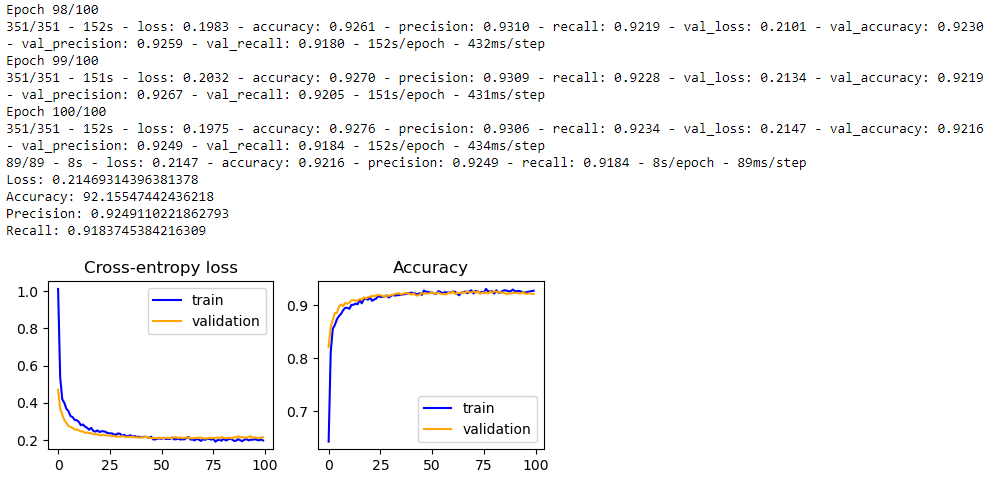

<b>InceptionV3:</b> Data augmentation (351 batches), batchnormalization, dropout with 0.3 rate, learning_rate = 0.0001 (RMSprop)

In [ ]:
#run InceptionV3 model
inceptionV3_model = run_validation_harness(InceptionV3_TL(), inception_v3, 'inceptionV3')

### InceptionV3 training results (snapshot)
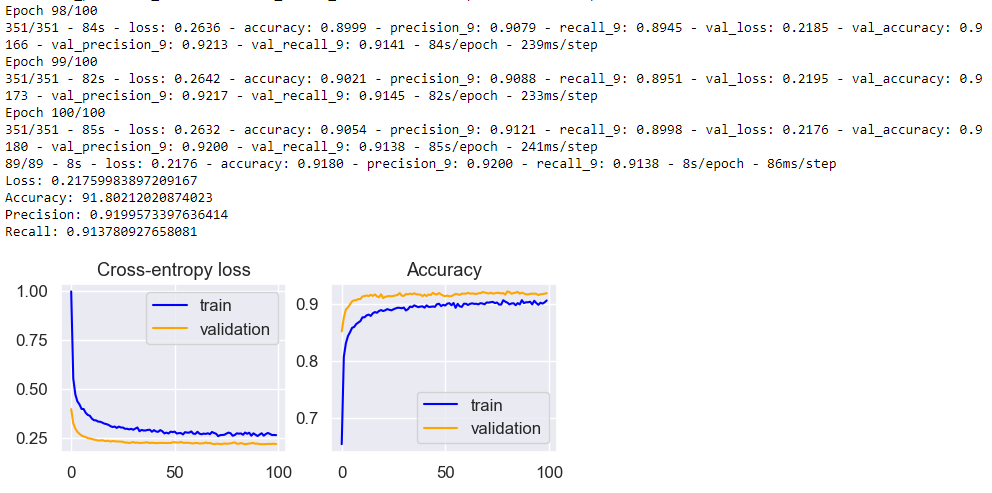

<b>EfficientNetB7:</b> Data augmentation (351 batches), GlobalAveragePoolong2D, batchnormalization, dropout with 0.3 rate, learning_rate = 0.0001 (Adam)

In [ ]:
#run EfficientNetB7 model
effnetB7_model = run_validation_harness(EfficientNetB7_TL(), efficientnet, 'efficientnetB7')

### EfficientNetB7 training results (snapshot)
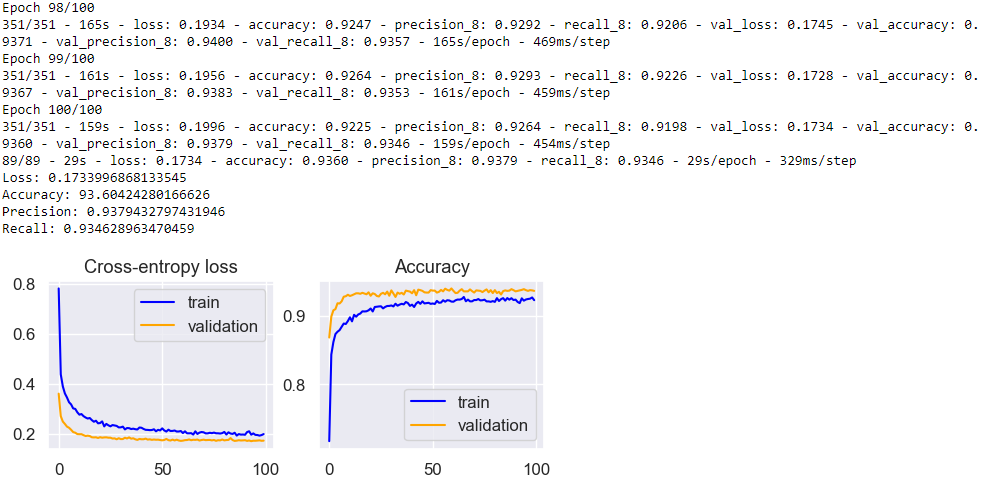

In [36]:
resnet50_model.load_weights('resnet50_weights.hdf5')
inceptionV3_model.load_weights('inceptionV3_weights.hdf5')
effnetB7_model.load_weights('efficientnetB7_weights.hdf5')

In [42]:
def preprocess_data(preprocess_config):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_config.preprocess_input)
    test_iterator = test_datagen.flow_from_directory('./kaggle/working/seg_test/', class_mode='categorical',\
                                                              shuffle=False, batch_size=32,\
                                                              target_size=(224, 224))
    return test_iterator

## Ensemble model performance on test data

In [90]:
all_y_preds = [model.predict(iterator) for model, iterator in \
               zip([resnet50_model, inceptionV3_model, effnetB7_model],\
                   [preprocess_data(resnet), preprocess_data(inception_v3), preprocess_data(efficientnet)])]

Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
94/94 [==============================] - 30s 326ms/step


In [107]:
all_y_preds = np.array(all_y_preds)
sum_y_preds = np.sum(all_y_preds, axis=0)
#Ensemble predictions
test_ensemble_labels = np.argmax(sum_y_preds, axis=1)
np.savetxt('ensemble_results_test.csv', test_ensemble_labels)

In [106]:
#Ensemble prediction accuracy
test_iterator = preprocess_data(resnet)
np.mean(test_ensemble_labels == test_iterator.classes)

0.9296666666666666

Classification accuracy of ensemble model: <b>0.9297</b>

### Confusion matrix - Ensemble Model

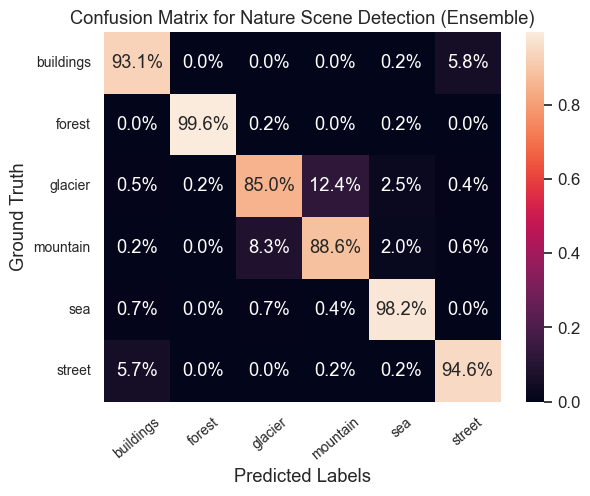

In [108]:
conf_matrix = confusion_matrix(test_iterator.classes, test_ensemble_labels)
plt.figure()
sns.set(font_scale=1.1)
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt='.1%')
ax.set_xlabel('Predicted Labels')
ax.xaxis.set_ticklabels(list(test_iterator.class_indices.keys()), fontsize=10, rotation=40)
ax.yaxis.set_ticklabels(list(test_iterator.class_indices.keys()), fontsize=10, rotation=0)
ax.set_ylabel('Ground Truth')
ax.set_title('Confusion Matrix for Nature Scene Detection (Ensemble)')
plt.show()

## References:

Some concepts are referred from these links:<br>
1. https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
2. https://www.kaggle.com/code/warcoder/issues-in-the-dataset-100-bird-species
3. https://github.com/cleanlab/cleanvision